In [1]:
#%pip install feos
#%pip install gpy
#%pip install emukit

import numpy as np
import pandas as pd
import glob, os
from feos.si import * # SI numbers and constants
from feos.pcsaft import *
from feos.eos import *
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize,curve_fit

from entropy_scaling import *
from multi_entropy_utils import *


import GPy
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper

import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

np.random.seed(20)

In [2]:
saft_paras = "20191105_pure_parameters_feos.json"

##################################

name = "butanol"
experimental_noise = 0.01
tmin = 273.15
tmax = 330.15
pmin = 0.99802 
pmax = 100.005
design_no = 5


#name = "propane"
#experimental_noise = 0.01
#tmin = 273.15
#tmax = 320.15
#pmin = 65.0
#pmax = 71.0131
#design_no = 5



viscosity_reference = get_CE_viscosity_reference

#vis_path = "mayer_kabelac_LJ_data.txt"
#colnames=[ "rho", "T", "eta", "eta_kk", "eta_kp", "eta_pp", "G_p_infty", "G_kp_max" , "comments" ] 
#data_tp = pd.read_csv(vis_path, names=colnames, header=None, delimiter=r"\s+")
#data_tp = data_tp[ ["rho", "T", "eta"] ].dropna()
#refLJ = LJ_mayer_kabelac(np.array(data_tp["T"]), np.array(data_tp["rho"]),np.array(data_tp["eta"]))
#viscosity_reference = refLJ.get_LJ_viscosity_reference

simdata: database


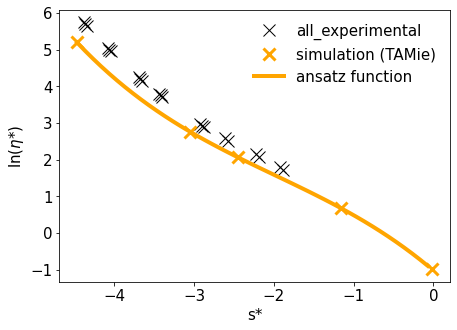

In [3]:
units = {}
units["temperatures"] = KELVIN
units["densities"]    = KILOGRAM/METER**3  
units["viscosities"]  = MILLI*PASCAL*SECOND 
units["viscosity_reference"]  = MILLI*PASCAL*SECOND 
units["pressures"]    = KILO*PASCAL
units["residual_entropies"]    = 1.
units["ln_viscosity_star"]    = 1.
units["state"]    = False

try:
    os.mkdir(name)
except:
    None

path = name + "/poly_free/"    
try:
    os.mkdir(path)
except:
    None


saft_paras = "20191105_pure_parameters_feos.json"

# get PC-SAFT parameters
parameters = PcSaftParameters.from_json(
    [name.split("_")[0]], 
    saft_paras, 
    search_option="name"
)

M = parameters.pure_records[0].molarweight *(GRAM/MOL)
m = parameters.pure_records[0].model_record.m

"""
Here experimental data is loaded and processed.
Result: representation of experimental data in entropy space
"""

path_vis = name.split("_")[0]+"/experimental/"+name.split("_")[0]+".json" 


with open(path_vis) as json_file:
    all_experimental = json.load(json_file)

all_experimental = apply_units(all_experimental, units)    
all_experimental = viscosity_prho_entropy_space( all_experimental, parameters, viscosity_reference )

liquid_only = True
all_experimental = split_dataset(all_experimental, 
                                 np.squeeze(np.where( all_experimental["residual_entropies"] < -1 )),
                                 #np.squeeze(np.where( all_experimental["state"] == 'L' )),
                                 units
                                )

    
"""
Here simulation data is loaded and processed.
Result: representation of simulation results in entropy space
"""

# load simulation data 
  
print("simdata: database")
simdata = pd.read_excel( "simulations/simulation_results.xlsx" )
simdata = simdata[ simdata["molecule"] == name.split("_")[0] ]

# collect simulation data and assign units
simulation  = {}
simulation["temperatures"]     = np.array(simdata.temperature)*KELVIN
simulation["densities"   ]     = np.array(simdata.density)*KILOGRAM/METER**3
simulation["viscosities" ]     = np.array(simdata.viscosity)*MILLI*PASCAL*SECOND
simulation["pressures"   ]     = np.empty(len(simulation["temperatures"]))


simulation = viscosity_prho_entropy_space( simulation, parameters, viscosity_reference ) 

# fit polynomial ansatz function to simulation
simansatz = ansatz_test( simulation["residual_entropies"], simulation["ln_viscosity_star"], viscosity_correlation )
simansatz.train()

pex = np.squeeze(np.where(all_experimental["residual_entropies"] >= np.min(simulation["residual_entropies"]) ))
all_experimental = split_dataset( all_experimental, pex, units )

x_simrep = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_simrep,_ = simansatz.predict(x_simrep)
xdata   = [ all_experimental["residual_entropies"], simulation["residual_entropies"], x_simrep ]
ydata   = [ all_experimental["ln_viscosity_star"], simulation["ln_viscosity_star"],  y_simrep]
yfill   = [ "", "", "" ]
markers = [ "x", "x", "-" ] 
colors  = [ "black", "orange", "orange" ] 
labels  = [ "all_experimental", "simulation (TAMie)", "ansatz function" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_simulation_fit" )

exc [3 4 5 6 7 8]


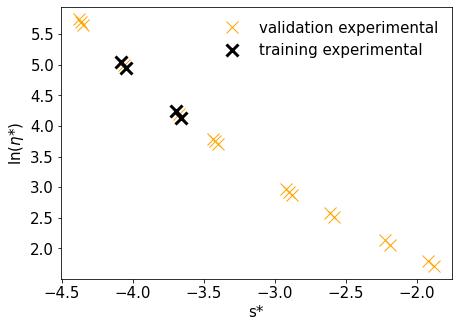

In [4]:
"""
split datasets for testing reasons
"""

a = np.squeeze( np.where(all_experimental["pressures"]/BAR > pmin  ))
b = np.squeeze( np.where(all_experimental["pressures"]/BAR < pmax  ))
ab = np.intersect1d(a,b)
c = np.squeeze( np.where(all_experimental["temperatures"]/KELVIN > tmin  ))
d = np.squeeze( np.where(all_experimental["temperatures"]/KELVIN < tmax  ))
cd = np.intersect1d(c,d)
try:
    abcd  = np.intersect1d(ab,cd)
    dududu = all_experimental["temperatures"]/KELVIN
    e = np.squeeze( np.where(dududu[abcd] > -10000))[~np.isnan(all_experimental["densities"]/(GRAM/METER**3) )]
    pdummy = np.intersect1d(abcd,e)
except:
    pdummy  = np.intersect1d(ab,cd)
    print("exc",pdummy)
    
entropy_dummy = all_experimental["residual_entropies"][pdummy]
entropy_space = np.linspace( np.min(entropy_dummy), np.max(entropy_dummy), design_no )

ptrain = []
for es in entropy_space:
    another_dummy = np.abs( entropy_dummy - es )
    pes = pdummy[np.squeeze( np.where( another_dummy == np.min(another_dummy) ) ) ]
    if pes.size > 1:
        pes=pes[0]
    #print(pes)
    ptrain.append(pes)
ptrain = np.unique(np.array(ptrain))

pval =  np.setdiff1d( np.squeeze( np.where(all_experimental["residual_entropies"] < 100  )), ptrain ) 

validation_experimental = split_dataset( all_experimental, pval, units )

experimental = split_dataset( all_experimental, ptrain, units )

xdata   = [ validation_experimental["residual_entropies"], experimental["residual_entropies"] ]
ydata   = [ validation_experimental["ln_viscosity_star"], experimental["ln_viscosity_star"] ]
yfill   = [ "", "" ]
markers = [ "x", "x" ] 
colors  = [ "orange", "black" ] 
labels  = [ "validation experimental", "training experimental" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels )

 /home/derwer/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning:Covariance of the parameters could not be estimated


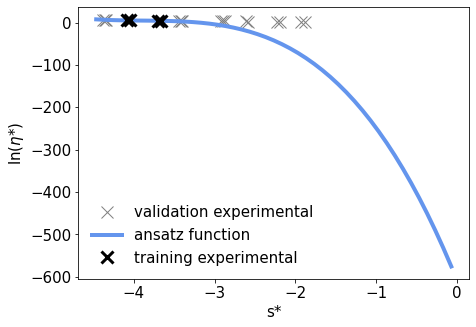

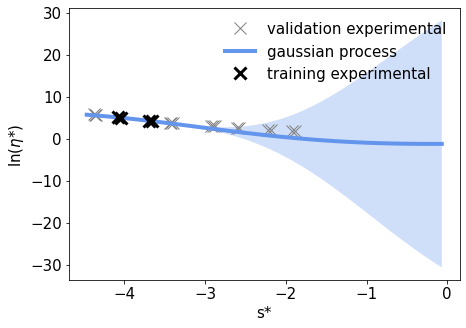

In [5]:
# fit  polynomial ansatz function to experimental 
exansatz = ansatz_test( experimental["residual_entropies"], experimental["ln_viscosity_star"], viscosity_correlation )
exansatz.train()

x_an = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_an,_ = exansatz.predict(x_an)
xdata   = [ validation_experimental["residual_entropies"], x_an, experimental["residual_entropies"] ]
ydata   = [ validation_experimental["ln_viscosity_star"], y_an, experimental["ln_viscosity_star"] ]
yfill   = [ "", "", "" ]
markers = [ "x", "-", "x" ] 
colors  = [ "grey", "cornflowerblue", "black" ] 
labels  = [ "validation experimental", "ansatz function", "training experimental" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_ansatz_fit"  )

# fit gaussian process to experimental 
exgp = gp_test( experimental["residual_entropies"], experimental["ln_viscosity_star"] )
exgp.train()

x_gp = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_gp, fillyy = exgp.predict(x_gp)
x_an = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_an,_ = exansatz.predict(x_an)
xdata   = [ validation_experimental["residual_entropies"], x_gp, experimental["residual_entropies"] ]
ydata   = [ validation_experimental["ln_viscosity_star"], y_gp, experimental["ln_viscosity_star"] ]
yfill   = [ "", fillyy, "" ]
markers = [ "x", "-", "x" ] 
colors  = [ "grey", "cornflowerblue", "black" ] 
labels  = [ "validation experimental", "gaussian process", "training experimental" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_gp_fit" )

In [6]:
# fit multi fidelity gaussian process to experimental 
kernels = [GPy.kern.RBF(1), GPy.kern.RBF(1) ]
exmf = multi_fidelity_test( experimental["residual_entropies"], simulation["residual_entropies"], 
                            experimental["ln_viscosity_star"],  simulation["ln_viscosity_star"],
                            kernels)

"""
fixing hyperparameters
- prevents overfitting
- takes account of noise in entropy space
- quite conservative choice i.e. we build on our hypothesis in case of doubt
"""
exmf.gpy_model.mixed_noise.Gaussian_noise.fix(0.001)
exmf.gpy_model.mixed_noise.Gaussian_noise_1.variance = 0.01#.fix(0.0)
exmf.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.01)
#exmf.gpy_model.multifidelity.scale = 1.0
#exmf.gpy_model.kern.rbf.lengthscale.fix(4.)
#exmf.gpy_model.kern.rbf_1.lengthscale.fix(.2)
exmf.train()  

print( "simulation", simulation["residual_entropies"] )
print( "experimental", experimental["residual_entropies"] )

Optimization restart 1/5, f = 2.7110948761008884
Optimization restart 2/5, f = 2.7109203943351297
Optimization restart 3/5, f = 2.7109203679090914
Optimization restart 4/5, f = 2.7109248475135495
Optimization restart 5/5, f = 2.7109203677122955
simulation [-4.46731137 -3.05429671 -2.44843561 -1.16336895 -0.01414523]
experimental [-4.04594984 -4.07981769 -3.65869568 -3.69564528]


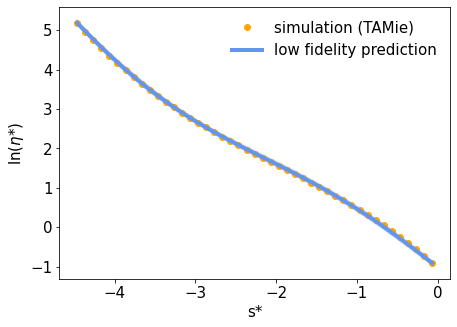

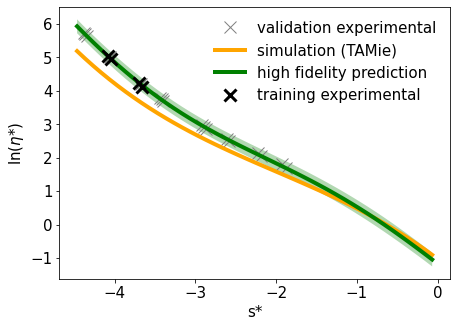

gp.,value,constraints,priors
multifidelity.rbf.variance,31.992711096160008,+ve,
multifidelity.rbf.lengthscale,3.05660651637739,+ve,
multifidelity.rbf_1.variance,3.7375408882873794e-11,+ve,
multifidelity.rbf_1.lengthscale,15.931477323484161,+ve,
multifidelity.scale,1.1430449534107587,,
mixed_noise.Gaussian_noise.variance,0.001,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,0.01,+ve fixed,


In [7]:
# predict and plot multi fidelity gaussian process versus experimental 
y_mf, mf_fill = exmf.predict(x_simrep)
y_mf_low, mf_fill_low = exmf.predict_low_fidelity(x_simrep)


xdata   = [ x_simrep, x_simrep ]
ydata   = [ y_simrep, y_mf_low ]
yfill   = [ "", mf_fill_low ]
markers = [ ".", "-" ] 
colors  = [ "orange", "cornflowerblue" ] 
labels  = [ "simulation (TAMie)", "low fidelity prediction" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_mf_low" ) 

xdata   = [ validation_experimental["residual_entropies"], x_simrep, x_simrep, experimental["residual_entropies"] ]
ydata   = [ validation_experimental["ln_viscosity_star"], y_simrep, y_mf, experimental["ln_viscosity_star"] ]
yfill   = [ "", "", mf_fill, "" ]
markers = [ "x", "-", "-", "x" ] 
colors  = [ "grey", "orange", "green", "black" ] 
labels  = [ "validation experimental", "simulation (TAMie)", "high fidelity prediction", "training experimental" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_mf_high" ) 

exmf.gpy_model #.kern

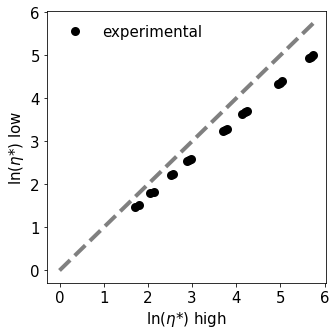

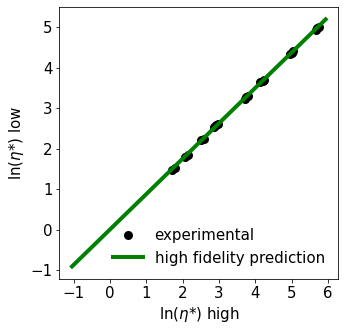

In [8]:
dummy, _ = exmf.predict_low_fidelity(all_experimental["residual_entropies"])

ddummy = np.linspace( 0, np.max( [np.max(all_experimental["ln_viscosity_star"]), np.max(dummy)] ),10 )

x_hi   = [ all_experimental["ln_viscosity_star"], ddummy ]
x_lo   = [ dummy, ddummy ]
markers = [ ".","--" ] 
colors  = [ "black","grey" ] 
labels  = [ "experimental","" ] 
linear_plot( x_hi, x_lo, markers, colors, labels, path+"subspace_expsim_angle" ) 


dummy, _ = exmf.predict_low_fidelity(all_experimental["residual_entropies"])
x_hi   = [ all_experimental["ln_viscosity_star"], y_mf ]
x_lo   = [ dummy, y_mf_low ]
markers = [ ".","-" ] 
colors  = [ "black","green" ] 
labels  = [ "experimental", "high fidelity prediction" ] 
linear_plot( x_hi, x_lo, markers, colors, labels, path+"subspace_mf_angle" ) 

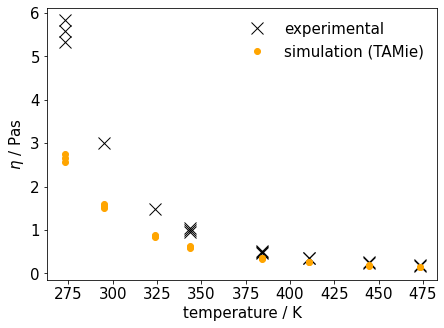

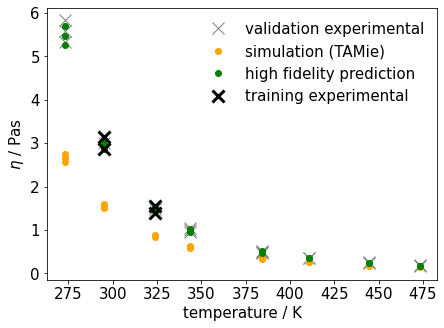

In [9]:
normer = all_experimental["viscosity_reference"]/units["viscosity_reference"]
yy_simrep = backtranslate( all_experimental["residual_entropies"], normer , simansatz)

yy_mf     = backtranslate( all_experimental["residual_entropies"] , normer, exmf)

yy_experimental = experimental["viscosities"]/units["viscosities"]
yy_experimental_val = validation_experimental["viscosities"]/units["viscosities"]
yy_experimental_all = all_experimental["viscosities"]/units["viscosities"]

xt_all = all_experimental["temperatures"]/KELVIN
xt = experimental["temperatures"]/KELVIN
xt_val = validation_experimental["temperatures"]/KELVIN

xdata   = [ xt_val,xt_all ]
ydata   = [ yy_experimental_val , yy_simrep ]
yfill   = [  "", "" ]
markers = [ "x", "." ] 
colors  = [ "black", "orange" ] 
labels  = [ "experimental", "simulation (TAMie)" ] 
superspace_plot( xdata, ydata, yfill, markers, colors, labels, path+"superspace_sim_comp" ) 

xdata   = [ xt_val,xt_all,xt_all, xt ]
ydata   = [ yy_experimental_val , yy_simrep, yy_mf, yy_experimental ]
yfill   = [  "", "", mf_fill, "" ]
markers = [ "x", ".", ".", "x" ] 
colors  = [ "grey", "orange", "green", "black" ] 
labels  = [ "validation experimental", "simulation (TAMie)", "high fidelity prediction", "training experimental" ] 
superspace_plot( xdata, ydata, yfill, markers, colors, labels, path+"superspace_mf_high" ) 

#print( np.mean( np.abs( (yy_mf - yy_experimental)/yy_experimental ) ) *100 )

In [10]:
normer = experimental["viscosity_reference"] /units["viscosity_reference"]
yref    = experimental["viscosities"] /units["viscosities"]

lval   = len(validation_experimental["residual_entropies"])
ltrain = len(experimental["residual_entropies"])

mf_error     = get_superspace_error( experimental["residual_entropies"],yref,normer,exmf)
ansatz_error = get_superspace_error( experimental["residual_entropies"],yref,normer,exansatz)
gp_error     = get_superspace_error( experimental["residual_entropies"],yref,normer,exgp)
sim_error     = get_superspace_error( experimental["residual_entropies"],yref,normer,simansatz)

normer  = validation_experimental["viscosity_reference"] /units["viscosity_reference"]
yref    = validation_experimental["viscosities"] /units["viscosities"]
mf_error_val     = get_superspace_error( validation_experimental["residual_entropies"],yref,normer,exmf)
ansatz_error_val = get_superspace_error( validation_experimental["residual_entropies"],yref,normer,exansatz)
gp_error_val     = get_superspace_error( validation_experimental["residual_entropies"],yref,normer,exgp)
sim_error_val     = get_superspace_error( validation_experimental["residual_entropies"],yref,normer,simansatz)

mf_error_tot = (mf_error*ltrain + mf_error_val*lval)/( ltrain+lval )

sim_error_tot = (sim_error*ltrain + sim_error_val*lval)/( ltrain+lval )

print("training data ",ltrain)
print("validation data ",lval)
print("mf_error ", mf_error, mf_error_val, mf_error_tot)
print("an_error ", ansatz_error, ansatz_error_val)
print("gp_error ", gp_error, gp_error_val)
print("sim_error ", sim_error, sim_error_val,sim_error_tot)

training data  4
validation data  17
mf_error  1.5321200702833986 1.8914016047151994 1.8229670267281899
an_error  1.834745390999054e-11 86.85091952887615
gp_error  1.36010671448761 39.287121478084536
sim_error  44.76518699239595 35.704320238425275 37.43019962013397


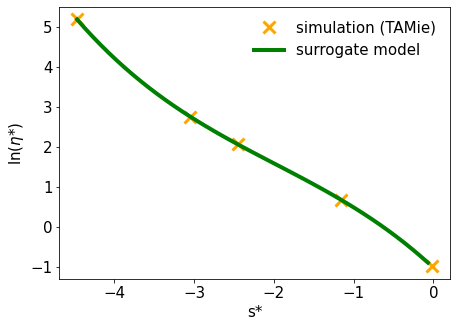

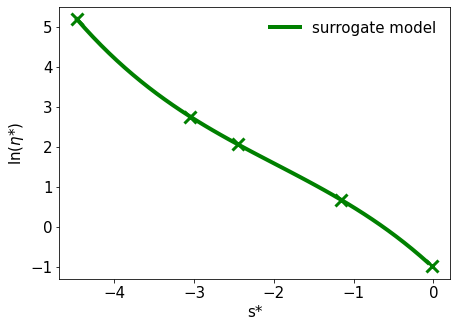

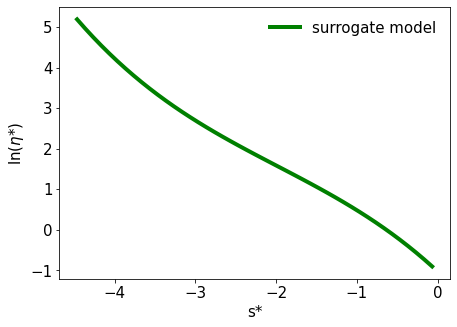

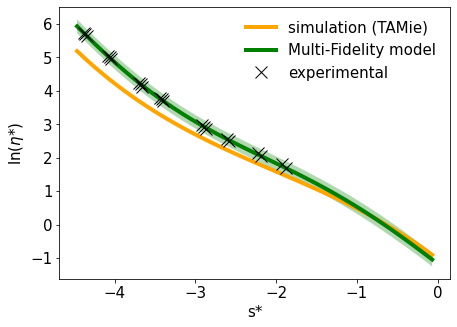

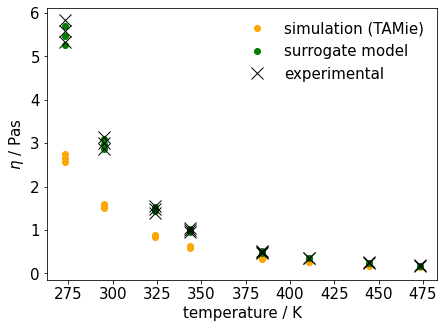

In [16]:
x_simrep = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_simrep,_ = simansatz.predict(x_simrep)
xdata   = [ x_simrep, simulation["residual_entropies"] ][::-1]
ydata   = [ y_simrep, simulation["ln_viscosity_star"] ][::-1]
yfill   = [ "", "" ]
markers = [ "-", "x" ][::-1] 
colors  = [ "green", "orange" ][::-1] 
labels  = [ "surrogate model","simulation (TAMie)" ][::-1] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_simulation_surr" )

xdata   = [ x_simrep, simulation["residual_entropies"] ][::-1]
ydata   = [ y_simrep, simulation["ln_viscosity_star"] ][::-1]
yfill   = [ "", "" ]
markers = [ "-", "x" ][::-1] 
colors  = [ "green", "green" ][::-1] 
labels  = [ "surrogate model","" ][::-1] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_simulation_map" )

xdata   = [ x_simrep ]
ydata   = [ y_simrep]
yfill   = [ "" ]
markers = [ "-" ]
colors  = [ "green" ]
labels  = [ "surrogate model" ]
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_surrogate" )

xdata   = [ x_simrep, x_simrep, all_experimental["residual_entropies"] ]
ydata   = [ y_simrep, y_mf, all_experimental["ln_viscosity_star"] ]
yfill   = [ "", mf_fill, "" ]
markers = [  "-", "-", "x" ] 
colors  = [ "orange", "green", "black" ] 
labels  = [  "simulation (TAMie)", "Multi-Fidelity model", "experimental" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_mf_high_map" )



xdata   = [ xt_all,xt_all,xt_all ]
ydata   = [ yy_simrep, yy_mf, yy_experimental_all  ]
yfill   = [  "", "", "", "" ]
markers = [ ".", ".", "x" ] 
colors  = [ "orange", "green", "black" ] 
labels  = [ "simulation (TAMie)", "surrogate model", "experimental" ] 
superspace_plot( xdata, ydata, yfill, markers, colors, labels, path+"superspace_mf_high_map" ) 


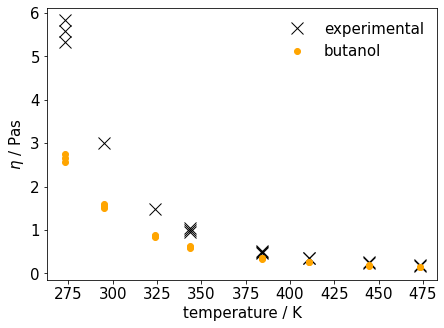

In [12]:
xdata   = [ xt_val,xt_all ]
ydata   = [ yy_experimental_val , yy_simrep ]
yfill   = [  "", "" ]
markers = [ "x", "." ] 
colors  = [ "black", "orange" ] 
labels  = [ "experimental", "butanol" ] 
superspace_plot( xdata, ydata, yfill, markers, colors, labels, path+"superspace_sim_comp_butanol" ) 